# Eigengene SVA Analysis

**Created**: 13 December 2021

## Environment

In [1]:
if (!requireNamespace("patchwork", quietly=TRUE)) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("GenomicRanges", quietly=TRUE)) {
    BiocManager::install("GenomicRanges")
}

In [2]:
library(tidyverse)
library(data.table)
library(parallel)
library(patchwork)
library(GenomicRanges)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapp

## Load Data

In [3]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

## Manhattan Plots

The genome-wide significance threshold is calculated using a Bonferroni correction of a significance threshold of 0.05. We performed tests for 66 individual eigengenes for 70300 SNPs. This threshold is slightly larger than 1e-8, so I will use that cutoff instead.

Under the null distribution, $t=\frac{\hat{\beta}}{SE}$ follows a T distribution with degrees of freedom close to $n$. The genomic inflation score measures the deviation from this expected distribution while accounting for outliers expected from a few true positives. The score is

$$\lambda = \frac{\text{median}(t^2)}{\text{median}(\chi_1^2)}$$

where $t$ is the T-statistic for $\beta$. Here, we assume that the T Distribution can be approximated as a standard normal distribution since $n$ is relatively large.

In [4]:
me.assocs <- do.call(rbind, lapply(list.files("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", pattern="*.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
}))

In [5]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

In [6]:
num.modules <- length(unique(me.assocs$me))
num.snps <- length(unique(me.assocs$snp))

In [7]:
me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::slice_min(p, n=1) %>%
    dplyr::arrange(p)

snp,beta,se,t,p,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs57213017,0.054451857,0.0008028893,67.819883,8.737541e-291,ME_69,17,0,45589540,C,G
rs9349181,0.050972719,0.0009011165,56.566180,1.430974e-250,ME_79,6,0,41217867,C,A
rs74011998,0.052846716,0.0011283076,46.837152,1.415121e-207,ME_97,15,0,48304516,C,T
rs999185,0.046176126,0.0010447932,44.196426,3.146183e-194,ME_94,12,0,9960659,T,C
rs8112960,-0.031717205,0.0009187555,-34.521923,4.513676e-148,ME_80,19,0,21592569,T,C
rs1677682,-0.018487645,0.0006131900,-30.149945,6.657138e-124,ME_82,5,0,80660774,A,C
rs1597245,0.033960781,0.0011551034,29.400642,1.082713e-119,ME_88,2,0,113690640,C,G
rs36053285,-0.027730358,0.0009777127,-28.362482,1.493487e-114,ME_104,15,0,100574435,C,T
rs6558370,-0.018048287,0.0007414044,-24.343375,2.794314e-92,ME_89,8,0,143535521,A,G


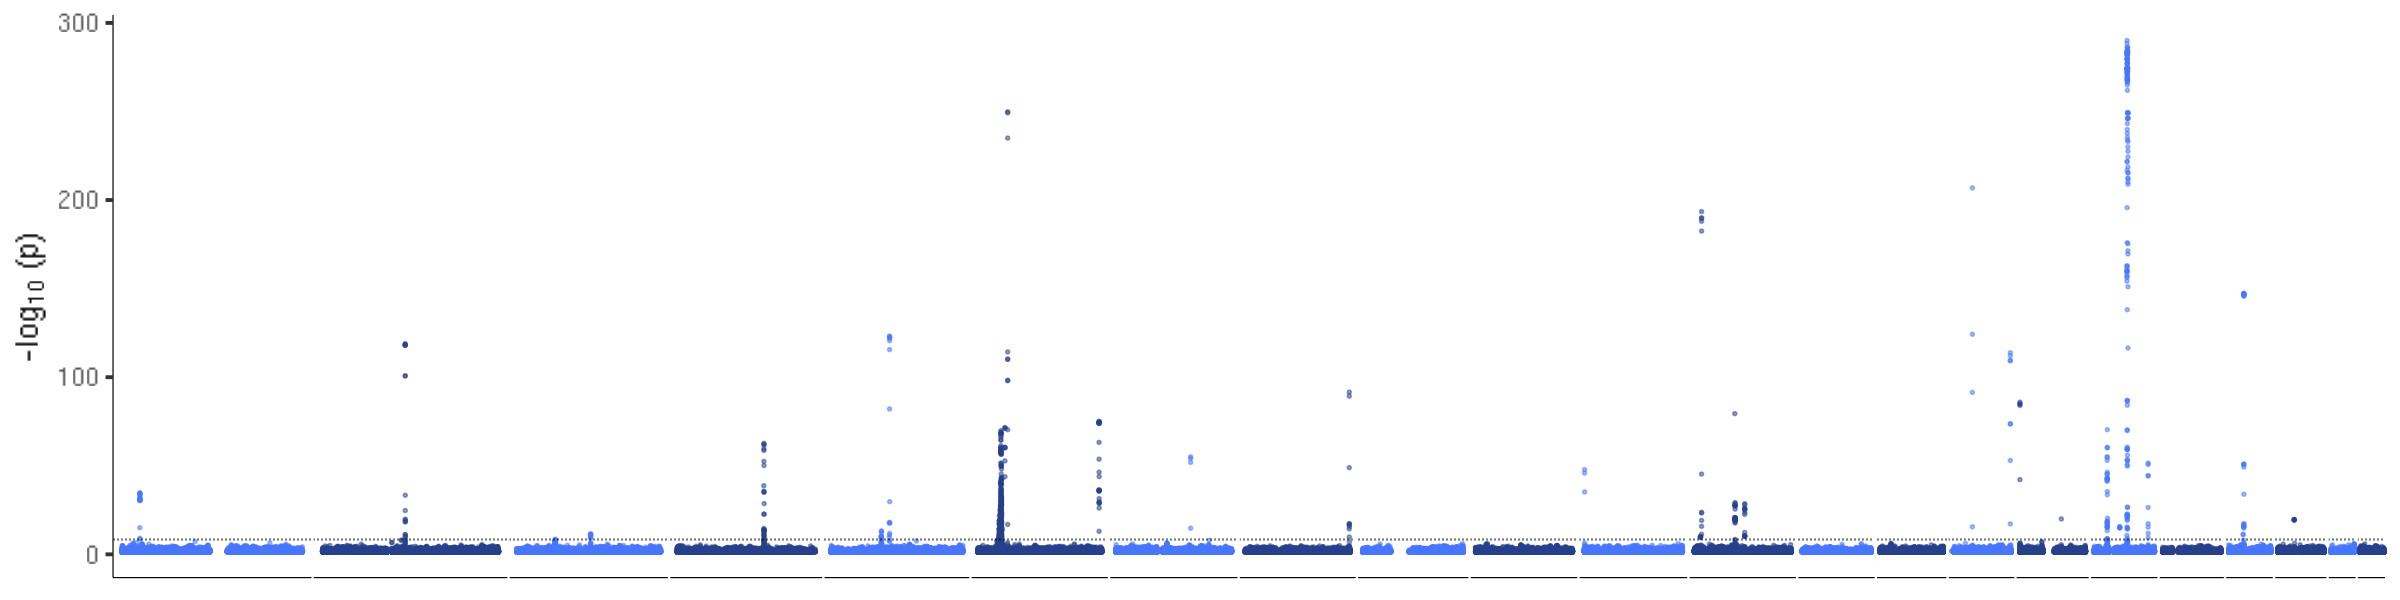

In [8]:
options(repr.plot.width=20, repr.plot.height=5)

plot.data <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

plot.data %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(0.05 / (num.modules * num.snps)), lty=3, size=0.5) +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        strip.background=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_blank(),
        axis.title.x=element_blank()
    )

ggsave("04_Expression/results/manhattan_initial_pass.png", width=20, height=5, dpi=1200)

## Call Module QTL

For each module, I will create 1 Mb windows around each significant SNP. Then, I will merge these windows to create the full window for the module QTL. These will be used to calculate summary statistics for downstream colocalization analysis.

In [10]:
windows <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::mutate(start = sapply(pos, function(x) { max(1, x - 10^6) }), end = pos + 10^6 - 1)

windows.merged <- lapply(split(windows, windows$me), function(x) {
    ranges <- makeGRangesFromDataFrame(x, seqnames.field="chr", start.field="start", end.field="end") %>%
    reduce() %>%
    as.data.frame()
    ranges$me <- x$me[1]
    return(ranges)
}) %>%
    do.call(rbind, .) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

In [11]:
snp.ranges <- makeGRangesFromDataFrame(
    as.data.frame(geno.bim), 
    seqnames.field="chr", start.field="Position", end.field="Position", 
    keep.extra.columns=TRUE
)

In [12]:
overlaps <- findOverlaps(windows.merged, snp.ranges)

In [13]:
module.qtl.snps <- cbind(
    as.data.frame(windows.merged)[overlaps@from,],
    as.data.frame(snp.ranges)[overlaps@to,]
) %>%
    as.data.frame() %>%
    dplyr::select(me, snp, chr=1, start=2, end=3) %>%
    dplyr::mutate(QTL.ID=paste0(chr, ":", start, "-", end)) %>%
    dplyr::select(ME=me, SNP=snp, QTL.ID)

In [17]:
head(module.qtl.snps)

,ME,SNP,QTL.ID
,<chr>,<chr>,<chr>
ME_101.1,ME_101,rs570214486,1:24243590-26454176
ME_101.1.1,ME_101,1:24244103_0_G,1:24243590-26454176
ME_101.1.2,ME_101,rs118121369,1:24243590-26454176
ME_101.1.3,ME_101,rs141756820,1:24243590-26454176
ME_101.1.4,ME_101,rs7516592,1:24243590-26454176
ME_101.1.5,ME_101,rs12081557,1:24243590-26454176


In [18]:
write.table(
    module.qtl.snps, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl_full_summary_statistics_snps.txt", 
    sep="\t", row.names=F, quote=F
)

## P-Value Q-Q Plots

Under the null hypothesis, we expect p-values for multiple tests to have a uniform distribution. If there is inflation in the data (that is, variants are associated with the quantitative variable due to population stratification), this p-value distribution will be skewed towards significance. This is quantified with the genomic inflation factor ($\lambda$). We can also plot the Q-Q plot for the p-values to check for deviation from the expected distribution. The p-values for true significant hits (close to 0) should deviate from the distribution, but the rest (indicating true negatives) should follow the distribution faithfully.

In [15]:
me.assocs <- lapply(c("ME_69.tsv", "ME_79.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
})

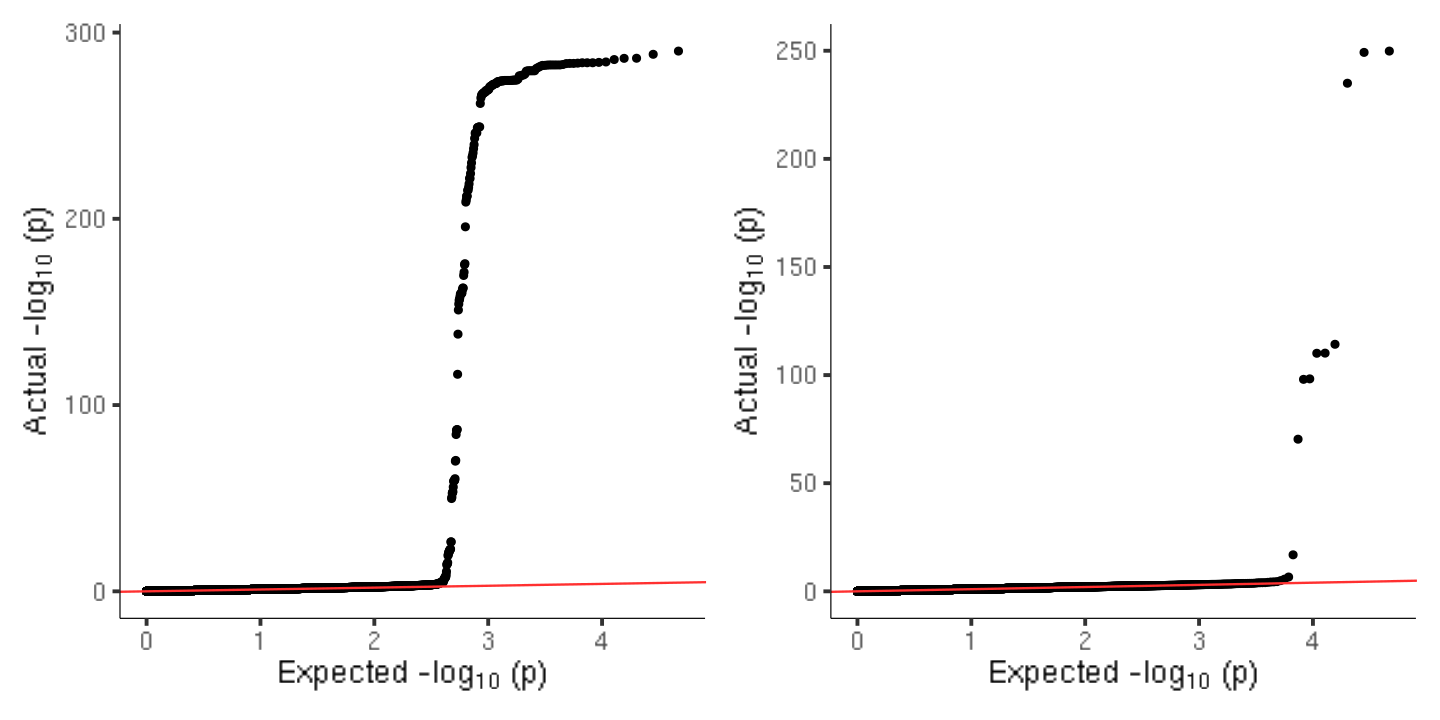

In [16]:
options(repr.plot.width=12, repr.plot.height=6)

exp.p.assocs <- lapply(me.assocs, function(me.assoc) {
    me.assoc %>%
        as.data.frame() %>%
        dplyr::mutate(expected.p=(rank(p, ties.method="first") + 0.5) / (length(p) + 1)) %>%
        dplyr::mutate(Log.10.P=-log10(p)) %>%
        dplyr::mutate(Expected.Log.10.P=-log10(expected.p))
})

plots <- lapply(exp.p.assocs, function(exp.p.assoc) {
    dplyr::bind_rows(
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P < 5) %>% dplyr::sample_frac(0.001),
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P >= 5)
    ) %>%
        ggplot() +
        geom_point(aes(x=Expected.Log.10.P, y=Log.10.P)) +
        geom_abline(slope=1, intercept=0, color="firebrick1") +
        xlab(expression("Expected -log"[10]~"(p)")) +
        ylab(expression("Actual -log"[10]~"(p)")) +
        ggplot_theme
})

plots[[1]] + plots[[2]]